### 1. Intial sizes of images
Find the images are in exact pixel sizes or 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import os
from PIL import Image
from sklearn.neighbors import NearestNeighbors

# image directory
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
# get 10 images
image_files = os.listdir(image_dir)[:10]

for i, file_name in enumerate(image_files, 1):
    # iterate over the image files that get and
    # join the path to open each image
    image_path = os.path.join(image_dir, file_name)
    with Image.open(image_path) as img:
        print(f"Image {i}: {file_name} - Size: {img.size}") 

Image 1: ISIC_9730802.jpg - Size: (139, 139)
Image 2: ISIC_2834883.jpg - Size: (125, 125)
Image 3: ISIC_5115027.jpg - Size: (123, 123)
Image 4: ISIC_3264822.jpg - Size: (115, 115)
Image 5: ISIC_1950204.jpg - Size: (147, 147)
Image 6: ISIC_8411738.jpg - Size: (145, 145)
Image 7: ISIC_3744117.jpg - Size: (133, 133)
Image 8: ISIC_0989720.jpg - Size: (131, 131)
Image 9: ISIC_3926794.jpg - Size: (139, 139)
Image 10: ISIC_2892810.jpg - Size: (107, 107)


In [2]:
meta_dir = "/kaggle/input/isic-2024-challenge/"

# read the csv file
df = pd.read_csv(meta_dir + "train-metadata.csv")

# display head
df.head()

/tmp/ipykernel_35/2766109314.py:4: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(meta_dir + "train-metadata.csv")
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/format

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [3]:
# for training the encoder we need only positive cases
# so others are drop by the dataframe
df_filtered = df[df["target"] == 1].reset_index(drop=True)

# show the new data frame
df_filtered.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,IL_7881385,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683
1,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,IL_5240575,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590
2,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,IL_1702337,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170
3,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,IL_3266850,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270
4,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,IL_2429082,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846


### 2. Sample view on the malignant skin images

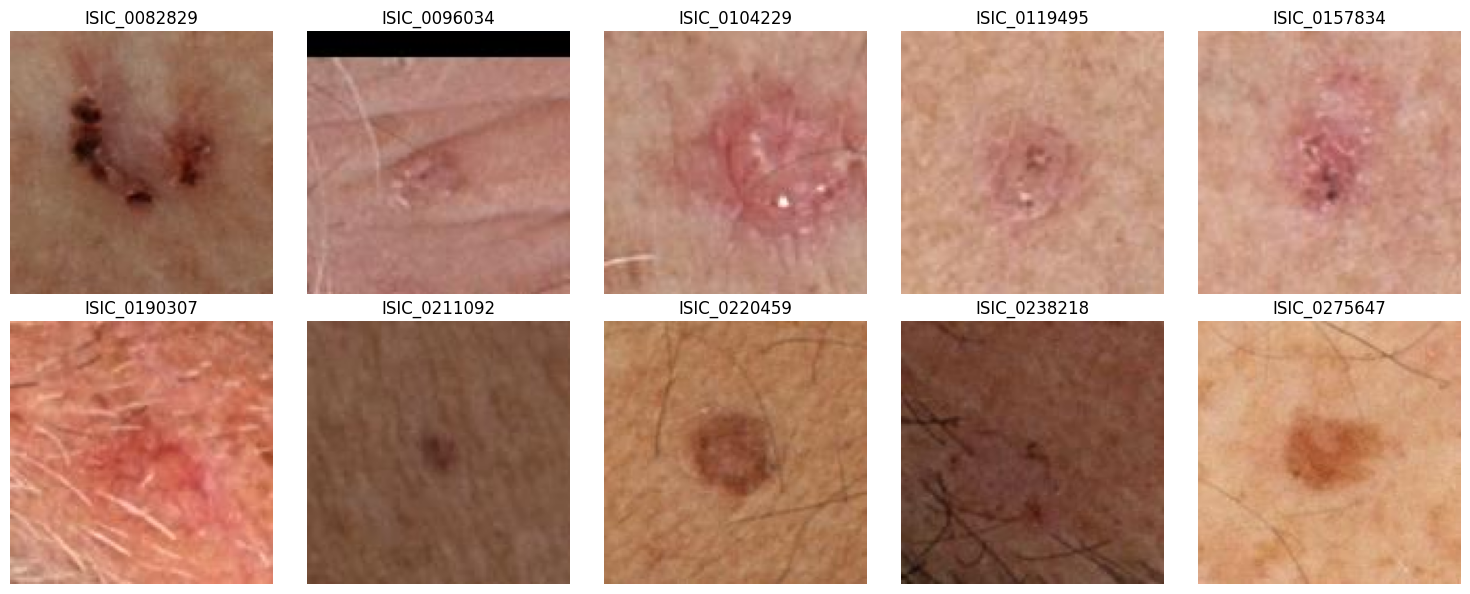

In [4]:
import matplotlib.pyplot as plt

# get first 10 isic_ids as sample and view them 
isic_ids = df_filtered['isic_id'].head(10)

# plot the images
plt.figure(figsize=(15, 6))
for i, isic_id in enumerate(isic_ids):
    image_path = os.path.join(image_dir, f"{isic_id}.jpg")
    img = Image.open(image_path)
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(isic_id)
    plt.axis('off')

plt.tight_layout()
plt.show()

### 3. Image resize to 128*128 size images

Images are in different image sizes so this different image sizes are made to same size images

ISIC_0082829: (128, 128)
ISIC_0096034: (128, 128)
ISIC_0104229: (128, 128)
ISIC_0119495: (128, 128)
ISIC_0157834: (128, 128)
ISIC_0190307: (128, 128)
ISIC_0211092: (128, 128)
ISIC_0220459: (128, 128)
ISIC_0238218: (128, 128)
ISIC_0275647: (128, 128)


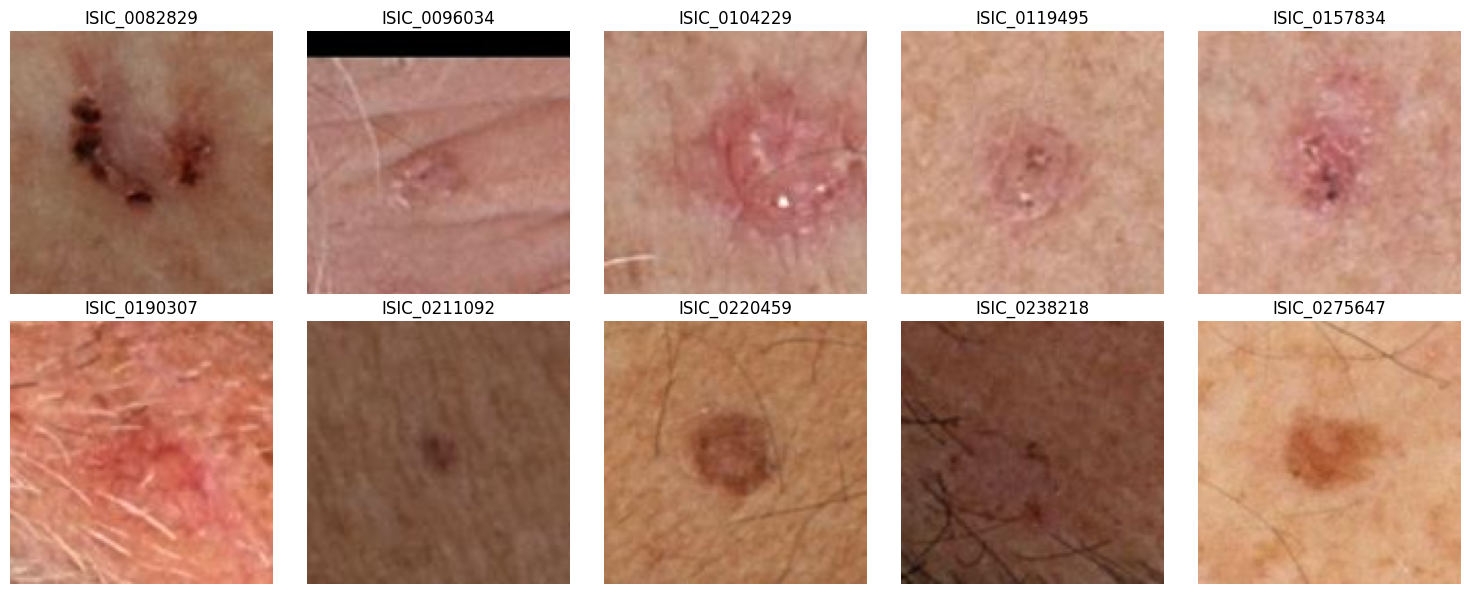

In [5]:
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
save_dir = '/kaggle/working/resized_images'
os.makedirs(save_dir, exist_ok=True)

# get sample 10 images to test
isic_ids = df_filtered['isic_id'].head(10)

# plot resized images
plt.figure(figsize=(15, 6))
for i, isic_id in enumerate(isic_ids):
    image_path = os.path.join(image_dir, f"{isic_id}.jpg")
    img = Image.open(image_path)

    # fit image to 128x128
    img_resized = ImageOps.fit(img, (128, 128), method=Image.BICUBIC)

    # show the size of the image
    print(f"{isic_id}: {img_resized.size}")
    
    # save resized image
    save_path = os.path.join(save_dir, f"{isic_id}.jpg")
    img_resized.save(save_path)
    
    # show image in plot 
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_resized)
    plt.title(isic_id)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
# check for specific classes 
# there are classes in the malignant data so we get the distinct cases 
unique_classes = df_filtered['iddx_3'].unique()
print("Distinct classes in 'iddx_3':", unique_classes)
print("Distinct classes", len(unique_classes))

# count occurrences of each class
class_counts = df_filtered['iddx_3'].value_counts()
print("Class counts in 'iddx_3':\n", class_counts)

Distinct classes in 'iddx_3': ['Squamous cell carcinoma in situ' 'Basal cell carcinoma'
 'Squamous cell carcinoma, Invasive' 'Melanoma in situ'
 'Melanoma Invasive' 'Melanoma, NOS' 'Melanoma metastasis'
 'Squamous cell carcinoma, NOS']
Distinct classes 8
Class counts in 'iddx_3':
 iddx_3
Basal cell carcinoma                 163
Melanoma in situ                      80
Melanoma Invasive                     63
Squamous cell carcinoma in situ       49
Squamous cell carcinoma, Invasive     22
Melanoma, NOS                         13
Squamous cell carcinoma, NOS           2
Melanoma metastasis                    1
Name: count, dtype: int64


### 4. Sample generation code from the k-nearest 

generate samples from the data 
1. get random sample from the data (base points from the dataset)
2. for each data point, randomly choose one of its k neighbors (excluding itself)
3. get the real vector for each base points and the neighbours
4. generate new points by interpolating between each base and its chosen neighbor.

There are 8 different malignant() cases for that we need to generate seperate generation for each different cases.

In [6]:
# sample data of x
X = np.random.randn(10,5)
X.shape

(10, 5)

In [9]:
# X data size is the (number_of_dataset, n_vector_space)
# n_to_sample number of samples to generate
# cl means number of class the index of the class
def G_SM1(X, y,n_to_sample,cl):
    
    # fitting the model
    
    # if the incoming x data is more than 5 samples
    if (X.shape[0] > 5):
        n_neigh = 5 + 1
    else:
        # if not get the neighbors as available points
        n_neigh = X.shape[0]
        
    # initialize the model with the NearestNeighbors
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    
    # Returns indices of neighbors of each point
    # ind means the nearest neighbours to each point in
    dist, ind = nn.kneighbors(X)
    ##########
    # ind is the indexes of nearest neighbors that are close to the current index
    ##########
    
    # generating samples
    # get random index list from the data
    # base_indices that are get for generating new samples
    base_indices = np.random.choice(list(range(len(X))),n_to_sample)

    # considered neighbors that are
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    
    X_base = X[base_indices]
    X_neighbor = X[ind[base_indices, neighbor_indices]]

    samples = X_base + np.multiply(np.random.rand(n_to_sample,1),
            X_neighbor - X_base)
    print(samples)

In [10]:
G_SM1(X, 1, 5, 0)
base_indices = np.random.choice(list(range(len(X))),5)
print(base_indices)

[[ 0.69519523  0.45415675  0.85145604 -0.79170943  1.20440008]
 [ 0.8842101  -0.08503004 -0.58942351 -0.90415813  0.10351767]
 [ 1.25256147  0.25940007 -0.27236451  0.29892565 -0.09954696]
 [ 1.30257095 -0.33308863  0.62378224 -0.82537827 -0.04622833]
 [ 0.04681841  0.8882128   1.18367727 -0.78579979  0.86499308]]
[6 7 0 0 0]
